In [2]:
from sagemaker import get_execution_role

role = get_execution_role()
bucket='sagemaker-fashionmnist'

In [5]:
%%time
import pickle
import gzip
import numpy as np
import json

# Load Fashion-MNIST dataset
# urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
fashion_mnist_file = 'fashion-mnist.pkl.gz'
with gzip.open(fashion_mnist_file, 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f)

CPU times: user 956 ms, sys: 224 ms, total: 1.18 s
Wall time: 1.18 s


In [29]:
import sagemaker
dir(sagemaker)

['FactorizationMachines',
 'FactorizationMachinesModel',
 'FactorizationMachinesPredictor',
 'KMeans',
 'KMeansModel',
 'KMeansPredictor',
 'LDA',
 'LDAModel',
 'LDAPredictor',
 'LinearLearner',
 'LinearLearnerModel',
 'LinearLearnerPredictor',
 'LocalSession',
 'Model',
 'NTM',
 'NTMModel',
 'NTMPredictor',
 'PCA',
 'PCAModel',
 'PCAPredictor',
 'RealTimePredictor',
 'Session',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'absolute_import',
 'amazon',
 'container_def',
 'content_types',
 'estimator',
 'fw_utils',
 'get_execution_role',
 'local',
 'logs',
 'model',
 'predictor',
 'production_variant',
 's3_input',
 'session',
 'user_agent',
 'utils']

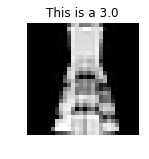

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2,10)


def show_fashion(img, caption='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

show_fashion(train_set[0][12513], 'This is a {}'.format(train_set[1][12513]))

앗 드레스네요!

In [7]:
from sagemaker import KMeans

data_location = 's3://{}/kmeans_highlevel_example/data'.format(bucket)
output_location = 's3://{}/kmeans_example/output'.format(bucket)

print('training data will be uploaded to: {}'.format(data_location))
print('training artifacts will be uploaded to: {}'.format(output_location))

kmeans = KMeans(role=role,
                train_instance_count=2,
                train_instance_type='ml.c4.8xlarge',
                output_path=output_location,
                k=10,
                data_location=data_location)

training data will be uploaded to: s3://sagemaker-fashionmnist/kmeans_highlevel_example/data
training artifacts will be uploaded to: s3://sagemaker-fashionmnist/kmeans_example/output


In [8]:
%%time

kmeans.fit(kmeans.record_set(train_set[0]))

INFO:sagemaker:Creating training-job with name: kmeans-2018-05-13-04-14-26-103


.....................................
Docker entrypoint called with argument(s): train
[05/13/2018 04:17:22 INFO 139730030782272] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["msd"]', u'_num_kv_servers': u'1', u'mini_batch_size': u'5000', u'half_life_time_size': u'0', u'_num_slices': u'1'}
[05/13/2018 04:17:22 INFO 139730030782272] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'784', u'mini_batch_size': u'5000', u'k': u'10', u'force_dense': u'True'}
[05/13/2018 04:17:22 INFO 139730

===== Job Complete =====
Billable seconds: 198
CPU times: user 7.53 s, sys: 300 ms, total: 7.83 s
Wall time: 3min 48s


In [9]:
%%time

kmeans_predictor = kmeans.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: kmeans-2018-05-13-04-28-57-339
INFO:sagemaker:Creating endpoint with name kmeans-2018-05-13-04-14-26-103


--------------------------------------------------------------!CPU times: user 216 ms, sys: 24 ms, total: 240 ms
Wall time: 5min 13s


In [23]:
result = kmeans_predictor.predict(valid_set[0][30:31])
print(result)

[label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 5.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 1415.9940185546875
    }
  }
}
]


In [24]:
%%time 

result = kmeans_predictor.predict(valid_set[0][0:100])
clusters = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 202 ms





Cluster 0:


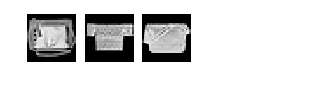




Cluster 1:


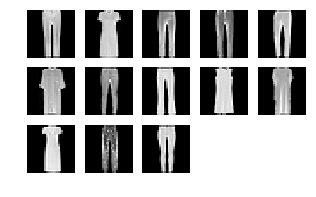




Cluster 2:


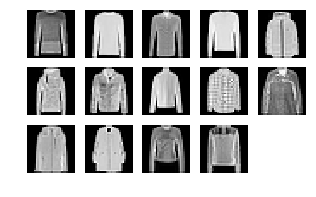




Cluster 3:


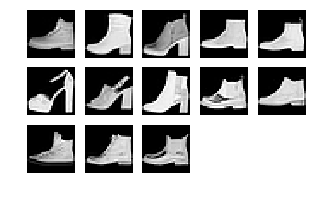




Cluster 4:


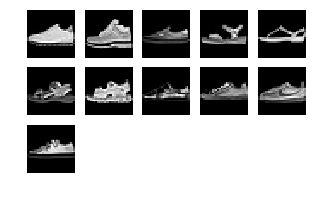




Cluster 5:


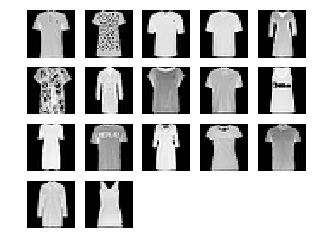




Cluster 6:


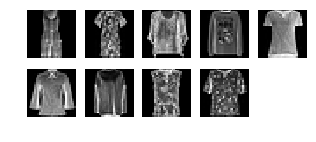




Cluster 7:


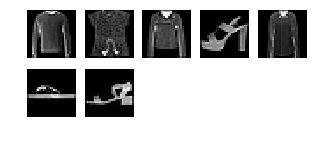




Cluster 8:


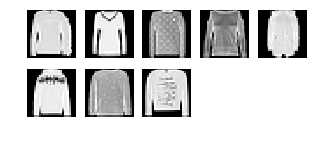




Cluster 9:


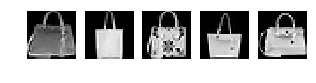

In [27]:
for cluster in range(10):
    print('\n\n\nCluster {}:'.format(int(cluster)))
    digits = [ img for l, img in zip(clusters, valid_set[0]) if int(l) == cluster ]
    height=((len(digits)-1)//5)+1
    width=5
    plt.rcParams["figure.figsize"] = (width,height)
    _, subplots = plt.subplots(height, width)
    subplots=np.ndarray.flatten(subplots)
    for subplot, image in zip(subplots, digits):
        show_fashion(image, subplot=subplot)
    for subplot in subplots[len(digits):]:
        subplot.axis('off')

    plt.show()